In [1]:
# pip install streamlit
# pip install python-dotenv
# pip install langchain_openai
# pip install langchain_experimental
import os
import pandas as pd
import streamlit as st
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from langchain.schema import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent # agents.agent_toolkits.csv.base.create_csv_agent

In [2]:
# Carregar variáveis de ambiente do arquivo .env
load_dotenv()

False

In [3]:
# Configuração da chave da API OpenAI e do modelo LLM
llm_name = 'gpt-4o-mini'
model = ChatOpenAI(
    api_key="YOUR-OPENAI-API-KEY", 
    model=llm_name, 
    temperature=0.0
)

In [4]:
# Carregar arquivo CSV e tratar valores ausentes
cols_to_use = ['fx_etaria', 'SRAG', 'SARS2', 'VSR', 'FLU', 'RINO', 'ADNO', 'BOCA', 'METAP', 'OUTROS', 'DS_UF_SIGLA', 'epiyear', 'epiweek']
df = pd.read_csv('https://gitlab.fiocruz.br/marcelo.gomes/infogripe/-/raw/master/Dados/InfoGripe/casos_semanais_fx_etaria_virus_sem_filtro_febre.csv', sep = ';', usecols=cols_to_use).fillna(value=0)

/var/folders/md/yxxtmrb15sl5j6kb9yqksm3c0000gn/T/ipykernel_60033/1168559176.py:3: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://gitlab.fiocruz.br/marcelo.gomes/infogripe/-/raw/master/Dados/InfoGripe/casos_semanais_fx_etaria_virus_sem_filtro_febre.csv', sep = ';', usecols=cols_to_use).fillna(value=0)


In [5]:
# Criar agente pandas para manipulação do DataFrame
agent = create_pandas_dataframe_agent(llm=model, df=df, verbose=True, allow_dangerous_code=True)

In [6]:
# Definir prefixo e sufixo do prompt para o agente
PROMPT_PREFIX = """
Você é um cientista de dados prestativo e suas respostas são concisas.

Você será fornecido um banco de dados em formato CSV de casos de Síndrome Respiratória Aguda Grave ('SRAG') que ocorreram no Brasil, em diferentes faixas etárias. Cada linha do banco de dados representa os casos de SRAG que ocorreram em uma determinada faixa etária (coluna 'fx_etaria'), em uma determinada Unidade Federativa ou no Brasil (coluna 'DS_UF_SIGLA'), em uma determinada semana epidemiológica (coluna 'epiweek'), em um determinado ano (coluna 'epiyear').

    O banco de dados possui as seguintes colunas:
    - 'SG_UF_NOT': ignore essa variável.
    - 'fx_etaria': A faixa etária, em anos, em que ocorreram os casos de SRAG. As categorias são: '< 2' para menores de 2 anos de idade; '2 a 4' para crianças de 2 a 4 anos de idade; '5 a 14' para pessoas de 5 a 14 anos de idade; '15 a 49' para pessoas de 15 a 49 anos, '50 a 64' para pessoas de 50 a 64 anos de idade; '65+' para pessoas com 65 ou mais anos de idade.
    - 'SRAG': O número de casos total de Síndrome Respiratória Aguda Grave (SRAG).
    - 'SARS2': O número de casos causados por SARS-CoV-2 (Covid 19).
    - 'VSR': O número de casos causados por Vírus Sincicial Respiratório.
    - 'FLU': O número total de casos causados por todos os vírus Influenza
    - 'RINO': O número de casos causados por Rinovírus.
    - 'ADNO': O número de casos causados por Adenovírus.
    - 'BOCA': O número de casos causados por Bocavírus.
    - 'METAP': O número de casos causados por Metapneumovírus.
    - 'OUTROS': O número de casos causados por outros vírus respiratórios.
    - 'DS_UF_SIGLA': Sigla das Unidades Federativas do Brasil, onde a sigla BR significa o somatório total para o Brasil inteiro.
    - 'epiyear': ano epidemiológico.
    - 'epiweek': semana epidemiológica.

Primeiro, remova todas as linhas onde fx_etaria seja 'Total' e remova todas as linhas onde DS_UF_SIGLA seja 'BR'. Ajuste as configurações de exibição do pandas para mostrar todas as colunas e as primeiras 6 linhas. Recupere os nomes das colunas e, em seguida, prossiga para responder à pergunta com base nos dados fornecidos.
"""

In [7]:
PROMPT_SUFFIX = """
- Antes de fornecer a resposta final sempre tente pelo menos um método adicional.
- Inicie a análise identificando se o usuário indicou alguma das faixas etárias corretas como constam no banco: '< 2' para menores de 2 anos de idade; '2 a 4' para crianças de 2 a 4 anos de idade; '5 a 14' para pessoas de 5 a 14 anos de idade; '15 a 49' para pessoas de 15 a 49 anos, '50 a 64' para pessoas de 50 a 64 anos de idade; '65+' para pessoas com 65 ou mais anos de idade.
- Se o usuário tiver pedido uma faixa etária que não seja um intervalo que conste do banco, interrompa a análise e diga quais são as faixas etárias possíveis.
- Reflita sobre os métodos e assegure-se de que os resultados respondem à pergunta original com precisão.
- Retorne sempre números, a menos que o usuário peça explicitamente um gráfico.
- Se o usuário pedir um gráfico, utilize a biblioteca seaborn.
- Formate qualquer número com quatro ou mais dígitos utilizando pontos para facilitar a leitura.
- Formate qualquer número real com casas decimais utilizando vírgula e arredondando para 3 casas decimais para facilitar a leitura.
- Se os resultados dos métodos forem diferentes, reflita e tente outra abordagem até que ambos os métodos se alinhem.
- Se ainda não conseguir chegar a um resultado consistente, reconheça a incerteza em sua resposta.
- Quando tiver confiança na resposta correta, elabore uma explicação detalhada e bem estruturada utilizando markdown.
- Sob nenhuma circunstância deve-se usar conhecimento prévio — confie unicamente nos resultados derivados dos dados e cálculos realizados.
- Como parte de sua resposta final, inclua uma seção de **Explicação** que descreva claramente como a resposta foi alcançada, mencionando nomes de colunas específicos utilizados nos cálculos.
- Como parte de sua resposta final, inclua o resultado dos cálculos e/ou filtragens realizadas.
"""


In [8]:
%matplotlib inline



> Entering new AgentExecutor chain...
Thought: Primeiro, preciso remover as linhas onde 'fx_etaria' seja 'Total' e onde 'DS_UF_SIGLA' seja 'BR'. Em seguida, ajustarei as configurações de exibição do pandas para mostrar todas as colunas e as primeiras 6 linhas. Depois, recuperarei os nomes das colunas para verificar se as faixas etárias estão corretas. 

Action: python_repl_ast
Action Input: 
import pandas as pd

# Supondo que o dataframe df já esteja carregado
# Remover linhas onde 'fx_etaria' é 'Total' e 'DS_UF_SIGLA' é 'BR'
df_filtered = df[(df['fx_etaria'] != 'Total') & (df['DS_UF_SIGLA'] != 'BR')]

# Ajustar configurações de exibição do pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Mostrar as primeiras 6 linhas e os nomes das colunas
df_filtered_head = df_filtered.head(6)
df_filtered_columns = df_filtered.columns.tolist()

df_filtered_head, df_filtered_columns(     fx_etaria  SRAG  SARS2  VSR  FLU  RINO  ADNO  BOCA  METAP  OUTROS  \


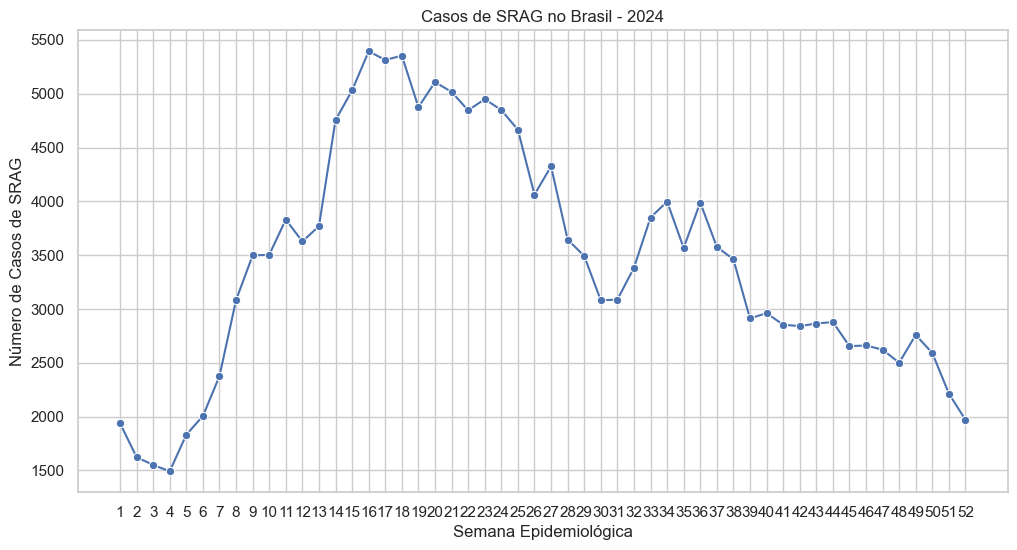

Thought: Agora que o gráfico de série temporal foi gerado, vou revisar os dados de casos de SRAG para 2024 e apresentar uma explicação detalhada sobre como a resposta foi alcançada, incluindo os números de casos e as etapas realizadas.

Final Answer: 

### Casos de SRAG no Brasil - 2024

Os dados de casos de Síndrome Respiratória Aguda Grave (SRAG) no Brasil para o ano de 2024 foram analisados e o gráfico de série temporal foi construído. Abaixo estão os números totais de casos de SRAG por semana epidemiológica:

| Semana Epidemiológica | Casos de SRAG |
|-----------------------|----------------|
| 1                     | 1.939          |
| 2                     | 1.624          |
| 3                     | 1.551          |
| 4                     | 1.493          |
| 5                     | 1.833          |
| 6                     | 2.006          |
| 7                     | 2.377          |
| 8                     | 3.083          |
| 9                     | 3.498          |
| 10     

In [9]:
# Exemplo de pergunta ao agente
# QUESTION = "Quantos casos de influenza ocorreram no Brasil em 2024?"
QUESTION = "Construa um gráfico de série temporal com os casos de SRAG no Brasil para 2024"
QUERY = PROMPT_PREFIX + QUESTION + PROMPT_SUFFIX

# Consulta e execução da resposta do agente
res = agent.invoke(QUERY, handle_parsing_errors=True)

In [10]:
# Aplicação Streamlit
st.title("Agente de IA do InfoGripe com Langchain")
st.write("### Preview do banco")
st.write(df.head())

# Entrada de pergunta pelo usuário
st.write('### Faça uma pergunta relacionada a SRAG no Brasil')
question = st.text_input(
    "O que você deseja saber sobre o banco de dados:",
    "Qual a média de casos de gripe no Mato Grosso do Sul, para cada semana epidemiológica disponível na base"
)

# Ação ao clicar no botão
if st.button("Run Query"):
    QUERY = PROMPT_PREFIX + question + PROMPT_SUFFIX
    res = agent.invoke(QUERY)
    st.write("### Resposta")
    st.markdown(res["output"])

# streamlit run agente_ai_infogripe.py

2025-02-06 11:13:36.487 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-06 11:13:36.633 
  command:

    streamlit run /Users/danielcamara/miniforge3/envs/ai_infogripe/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-02-06 11:13:36.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-06 11:13:36.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-06 11:13:36.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-06 11:13:36.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-06 11:13:36.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-06 1